# Integrantes
López Arguijo Luis Angel

Cortes Moreno Mauricio Hamabiel

Peralta Lezama Isaac

Arteaga Pérez Jesús Ángel

Morales Hernández Bruno Ricardo

Chávez Medina Mario

# Obtención de los textos

In [18]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15384 sha256=f5ca13a465f72dd737509c2f912afea26a2dddf2aa014991895c04d0ecbe8e18
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [26]:
import wikipediaapi
import pandas as pd
import time
import concurrent.futures

# Configurar Wikipedia API con User-Agent
user_agent = "MyWikipediaScraper/1.0 (contact: your_email@example.com)"
wiki = wikipediaapi.Wikipedia(language="en", user_agent=user_agent)

# Definir categorías de Wikipedia a extraer
categorias = {
    "politics": "Category:Political_terminology",
    "economics": "Category:Economics",
    "science": "Category:Science",
    "technology": "Category:Technology",
    "history": "Category:History",
    "medicine": "Category:Medicine",
    "sports": "Category:Sports"
}

# Función para identificar si un artículo es una biografía
def es_biografia(titulo):
    palabras_clave = ["born", "died", "biography", "person", "historian", "scientist", "politician"]
    return any(palabra in titulo.lower() for palabra in palabras_clave)

# Función para obtener artículos de una categoría (con límite de profundidad)
def obtener_articulos_categoria(categoria, min_articulos, profundidad_max=2):
    categoria_wiki = wiki.page(categoria)
    articulos_validos = set()

    def extraer_articulos(pagina, nivel):
        if nivel > profundidad_max:
            return  # Detenerse si se alcanza el nivel máximo

        for titulo, contenido in pagina.categorymembers.items():
            if len(articulos_validos) >= min_articulos:
                return  # Si ya tenemos suficientes, salimos

            if contenido.ns == wikipediaapi.Namespace.MAIN:  # Es un artículo real
                if not titulo.startswith("Category:") and not es_biografia(titulo):
                    articulos_validos.add(titulo)

            elif contenido.ns == wikipediaapi.Namespace.CATEGORY:  # Explorar subcategorías
                extraer_articulos(contenido, nivel + 1)

    extraer_articulos(categoria_wiki, nivel=0)

    return list(articulos_validos)[:min_articulos]  # Devolver solo los necesarios

# Función para obtener el texto de un artículo (con manejo de errores)
def obtener_texto(tema):
    pagina = wiki.page(tema)
    if pagina.exists():
        return pagina.text[:3000]  # Limitar a 3000 caracteres por artículo
    return None

# Extraer datos de Wikipedia usando concurrencia
datos = []

def procesar_categoria(categoria, categoria_wiki):
    print(f"\n🔍 Obteniendo artículos de la categoría: {categoria}...")

    articulos = obtener_articulos_categoria(categoria_wiki, min_articulos=400)

    resultados = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # 5 hilos concurrentes
        futuros = {executor.submit(obtener_texto, articulo): articulo for articulo in articulos}

        for futuro in concurrent.futures.as_completed(futuros):
            articulo = futuros[futuro]
            try:
                texto = futuro.result()
                if texto:
                    resultados.append([articulo, texto, categoria])
                    print(f"✅ {articulo} agregado ({categoria})")
            except Exception as e:
                print(f"❌ Error con {articulo}: {e}")

    return resultados

# Ejecutar extracción en paralelo
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:  # 3 categorías a la vez
    futuros = {executor.submit(procesar_categoria, cat, cat_wiki): cat for cat, cat_wiki in categorias.items()}

    for futuro in concurrent.futures.as_completed(futuros):
        datos.extend(futuro.result())

# Crear DataFrame con Pandas
df = pd.DataFrame(datos, columns=["title", "text", "category"])

# Mezclar aleatoriamente los artículos
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar en CSV
df.to_csv("wikipedia_data.csv", index=False, encoding="utf-8")

print(f"\n📂 Se han guardado {len(df)} artículos en 'wikipedia_data.csv'")



🔍 Obteniendo artículos de la categoría: politics...
🔍 Obteniendo artículos de la categoría: economics...


🔍 Obteniendo artículos de la categoría: science...
✅ Welfare chauvinism agregado (politics)
✅ Elements of national security agregado (politics)
✅ Social fascism agregado (politics)
✅ Political corruption agregado (politics)
✅ Practical idealism agregado (politics)
✅ Patriotism agregado (politics)
✅ Present bias agregado (economics)
✅ Sustainability metrics and indices agregado (economics)
✅ Low information voter agregado (politics)
✅ Pluralist democracy agregado (politics)
✅ Economic sociology agregado (economics)
✅ Masters in Agricultural Economics agregado (economics)
✅ Accountable autonomy agregado (politics)
✅ Journal of Behavioral and Experimental Economics agregado (economics)
✅ Teal organisation agregado (economics)
✅ Co-option agregado (politics)
✅ Government agregado (politics)
✅ Convertible husbandry agregado (economics)
✅ Representativity (politics) agregado (politics)

KeyboardInterrupt: 

✅ Natural rights and legal rights agregado (politics)
✅ Criminal investigation agregado (science)

In [57]:
df.to_csv("wikipedia_data.csv", index=False, encoding="utf-8")

print(f"\n📂 Se han guardado {len(df)} artículos en 'wikipedia_data.csv'")


📂 Se han guardado 2800 artículos en 'wikipedia_data.csv'


# 1. Tokenización y normalización

In [4]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("wikipedia_data.csv")

# Ver estructura
print(df.head())
print(f"\nEl dataset cuenta con {df.shape[0]} observaciones y {df.shape[1]} dimensiones.")

                                       title  \
0                             Binet equation   
1                The Computer Museum, Boston   
2                      Equipartition theorem   
3  Queen Elizabeth II Health Sciences Centre   
4                    Public affairs industry   

                                                text    category  
0  The Binet equation, derived by Jacques Philipp...     science  
1  The Computer Museum was a Boston, Massachusett...  technology  
2  In classical statistical mechanics, the equipa...     science  
3  Queen Elizabeth II Health Sciences Centre, in ...    medicine  
4  Public affairs generally refers to the engagem...    politics  

El dataset cuenta con 4200 observaciones y 3 dimensiones.


In [5]:
# Este es un ejemplo de uno de los textos que hay en el conjunto de datos junto con la categoria a la que pertenece.

print(f"Categoria del texto: {df.category[0]}\nTitulo del texto: {df.title[0]}\n\nTexto: {df.text[0]}")

Categoria del texto: science
Titulo del texto: Binet equation

Texto: The Binet equation, derived by Jacques Philippe Marie Binet, provides the form of a central force given the shape of the orbital motion in plane polar coordinates.  The equation can also be used to derive the shape of the orbit for a given force law, but this usually involves the solution to a second order  nonlinear, ordinary differential equation.  A unique solution is impossible in the case of circular motion about the center of force.

Equation
The shape of an orbit is often conveniently described in terms of relative distance 
  
    
      
        r
      
    
    {\displaystyle r}
  
 as a function of angle 
  
    
      
        θ
      
    
    {\displaystyle \theta }
  
.  For the Binet equation, the orbital shape is instead more concisely described by the reciprocal 
  
    
      
        u
        =
        1
        
          /
        
        r
      
    
    {\displaystyle u=1/r}
  
 as a funct

Si vamos al artículo podemos ver que no se obtiene todo el texto, solo una pequeña parte del inicio.

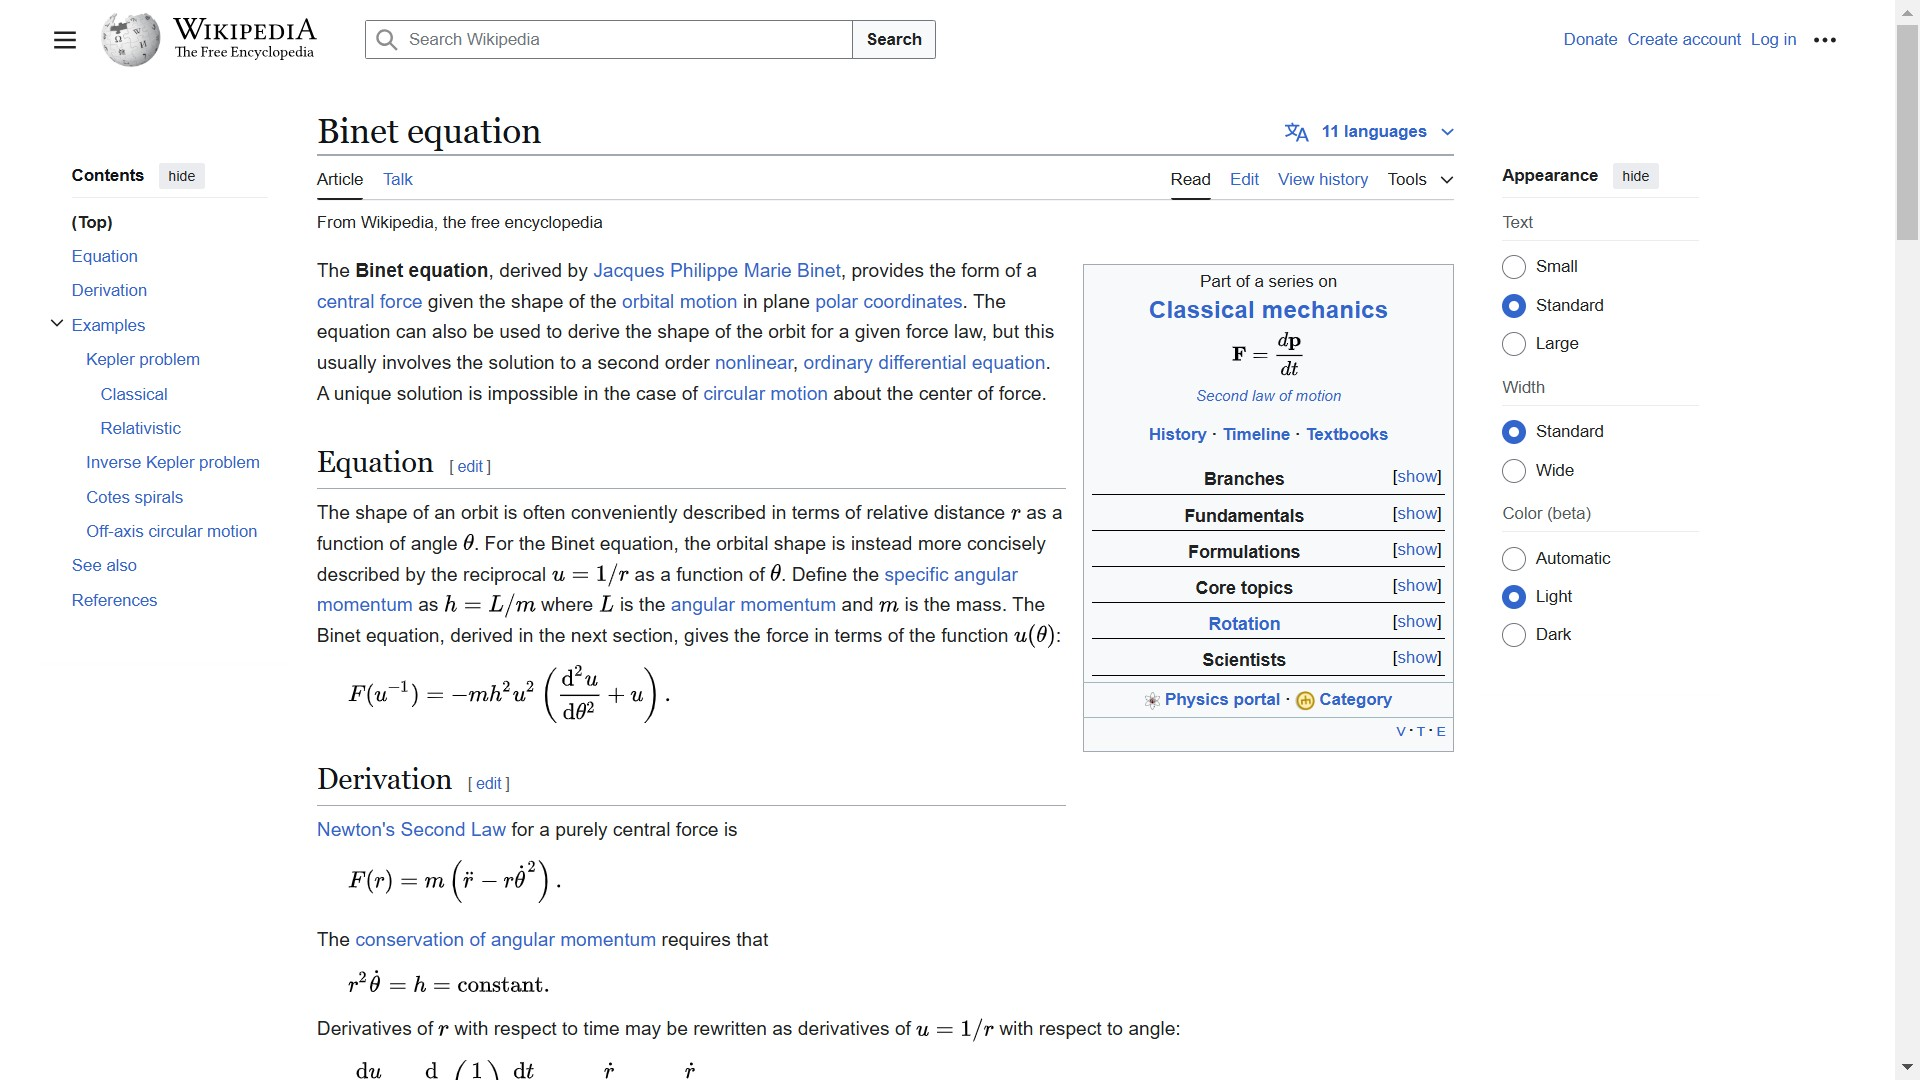

In [6]:
print(f"Categoria del texto: {df.category[925]}\nTitulo del texto: {df.title[925]}\n\nTexto: {df.text[925]}")

Categoria del texto: technology
Titulo del texto: Dinting Railway Centre

Texto: Dinting railway station serves the village of Dinting in Derbyshire, England. It is a stop on the Glossop line and, prior to the Woodhead Line's closure in 1981, Dinting was a station on the Great Central Main Line between Manchester Piccadilly and Sheffield Victoria.

History
An earlier station had been opened as Glossop by the Sheffield, Ashton-under-Lyne and Manchester Railway in 1842, but was renamed when the Glossop branch opened in 1845. In 1847, a temporary Glossop Junction station was built, on the site which the present station was built in 1848.  A direct west-to-south curve was added in 1884, when the station was rebuilt, allowing through running from Glossop to Manchester. 
For most of the day, all trains use platform 2; however, in the rush hour, platform 1 is the departure platform for services to Glossop via Hadfield, with platform 2 being used for trains to Manchester Piccadilly (although t

Observando otro ejemplo de texto podemos notar que los textos solo tiene la introducción y los 2 primeros dos subtemas.
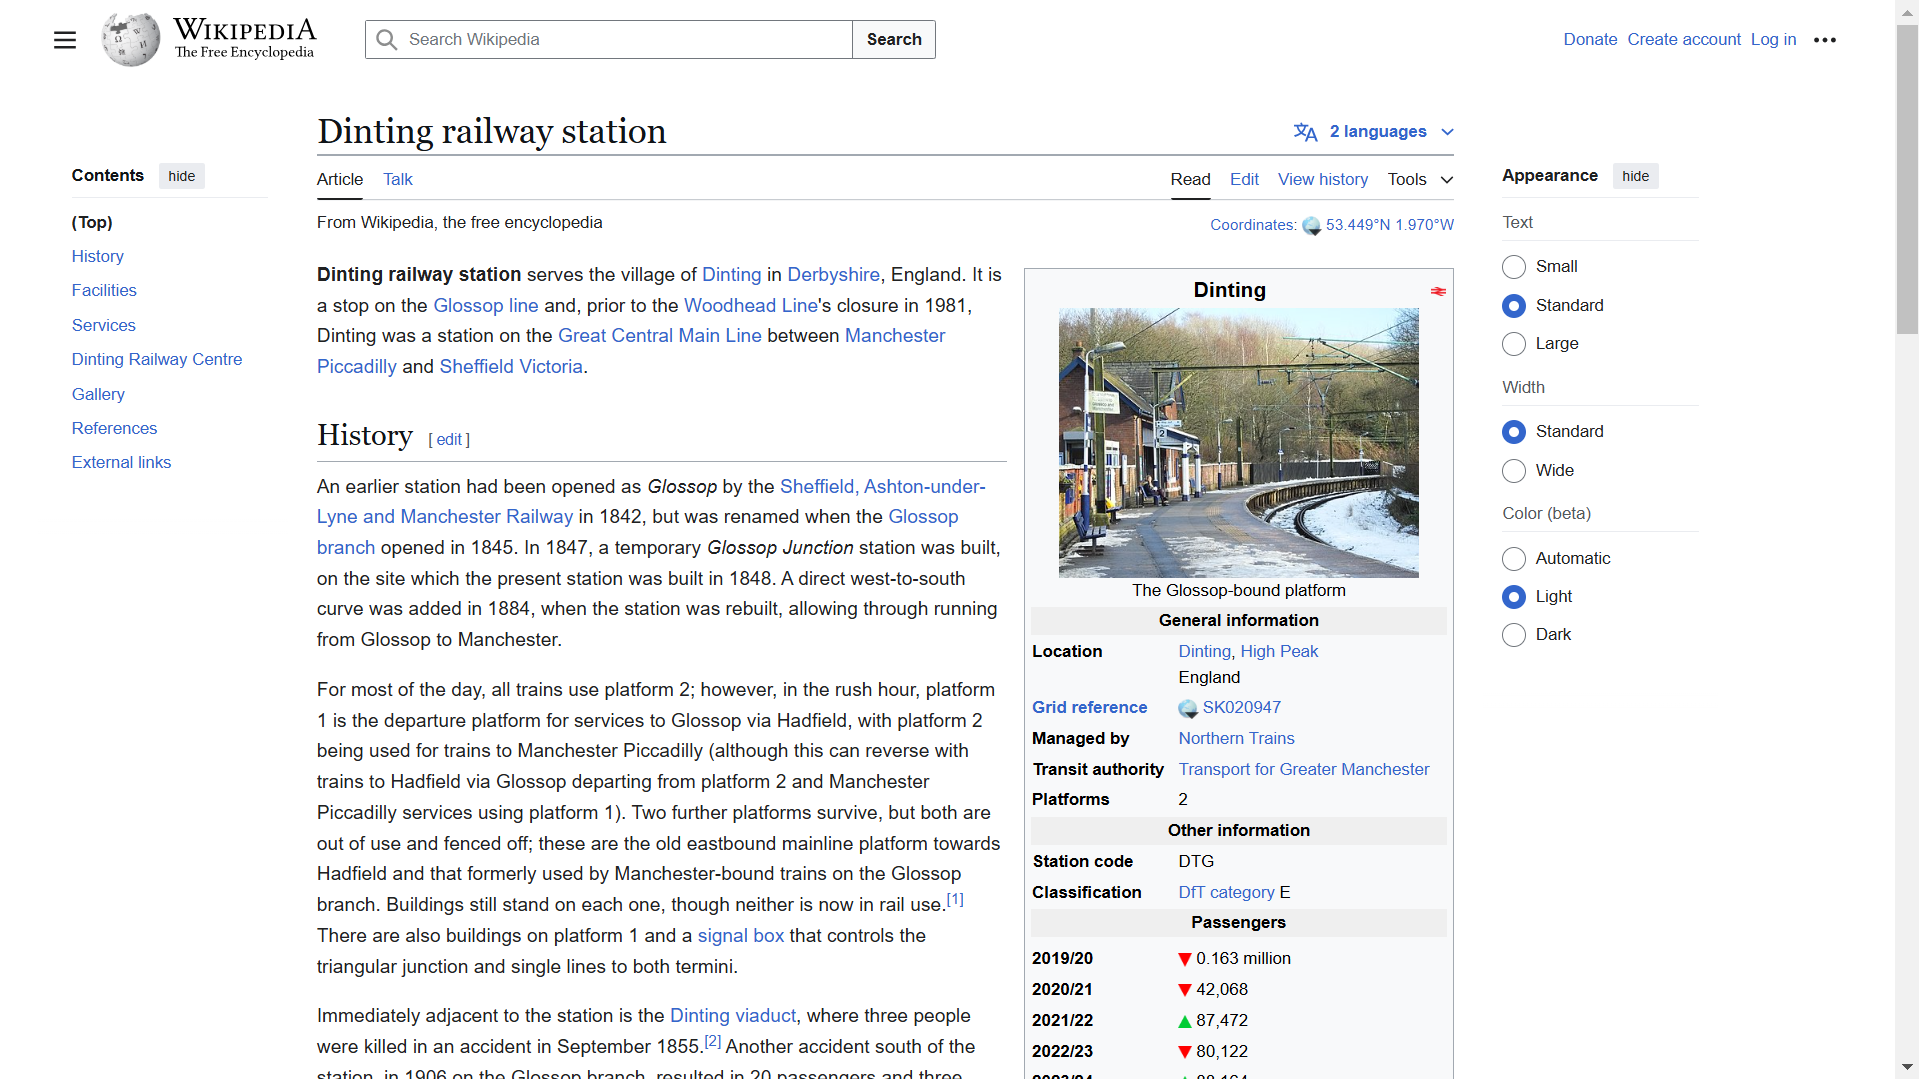
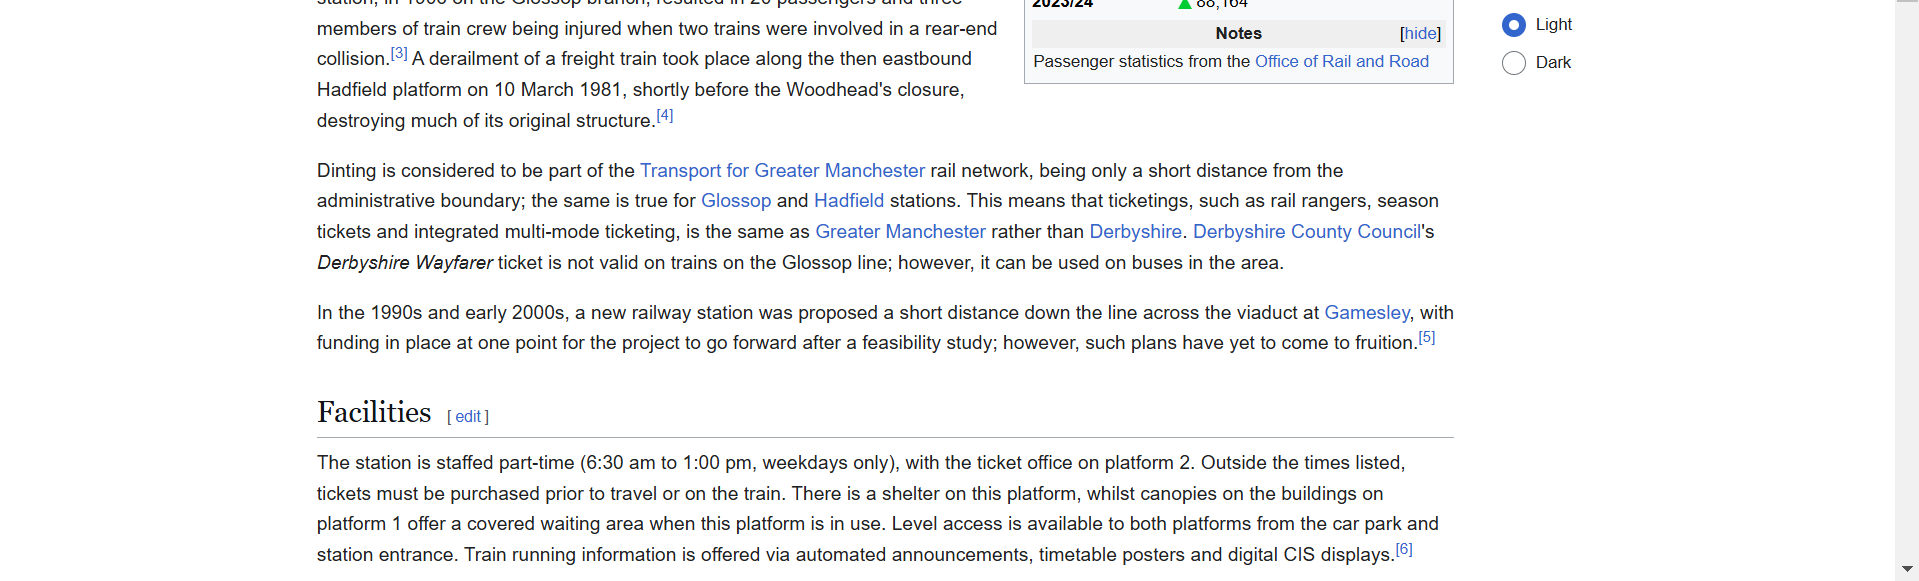

In [7]:
# Función para lematizar
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatization(tokens):
    return [lemmatizer.lemmatize(palabra) for palabra in tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
from collections import Counter
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# Separamos los textos por categoría
categorias = df['category'].unique()
articulos_por_categoria = {cat: " ".join(df[df['category'] == cat]['text']) for cat in categorias}

# Procesamos los textos y creamos los vocabularios de cada categoría
vocabularios_por_categoria = {}
for categoria, texto in articulos_por_categoria.items():
    tokens = word_tokenize(texto.lower())  # Tokenizar y convertir a minúsculas
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # Quitar stopwords y quedarse solo con palabras
    tokens = lemmatization(tokens)  # Lematización
    vocabularios_por_categoria[categoria] = tokens  # Guardar tokens procesados

# Imprimir ejemplo del vocabulario de 'politics'
print("\nEjemplo de acceso a textos procesados:")
print(vocabularios_por_categoria['politics'][:10])


Ejemplo de acceso a textos procesados:
['public', 'affair', 'generally', 'refers', 'engagement', 'effort', 'organization', 'often', 'time', 'context']


# 2. Extracción de Características lingüísticas

In [10]:
def obtener_palabras_frecuentes(tokens, n=50):
    conteo = Counter(tokens)  # Ahora recibe los tokens procesados
    return conteo.most_common(n)

# Observamos las 50 palabras más frecuentes de cada categoría
palabras_frecuentes_por_categoria = {cat: obtener_palabras_frecuentes(tokens) for cat, tokens in vocabularios_por_categoria.items()}
for categoria, palabras in palabras_frecuentes_por_categoria.items():
    print(f"\n🔹 Categoría: {categoria}")
    print(palabras)


🔹 Categoría: science
[('law', 1621), ('theorem', 1392), ('state', 914), ('system', 788), ('quantum', 743), ('constant', 730), ('theory', 694), ('energy', 620), ('particle', 600), ('field', 596), ('also', 558), ('equation', 556), ('x', 531), ('one', 528), ('r', 512), ('symmetry', 512), ('n', 508), ('v', 491), ('number', 484), ('gas', 477), ('time', 457), ('two', 450), ('p', 446), ('charge', 442), ('physical', 442), ('mass', 395), ('value', 394), ('b', 388), ('current', 370), ('first', 367), ('physic', 361), ('k', 357), ('e', 353), ('unit', 348), ('c', 344), ('used', 329), ('form', 323), ('example', 317), ('f', 313), ('conservation', 310), ('temperature', 306), ('mechanic', 305), ('pressure', 300), ('quantity', 300), ('volume', 295), ('given', 282), ('point', 277), ('h', 274), ('force', 273), ('function', 273)]

🔹 Categoría: technology
[('museum', 3172), ('history', 733), ('collection', 713), ('engine', 710), ('science', 660), ('company', 639), ('building', 610), ('also', 591), ('first'

In [11]:
def calcular_longitudes(texto):
    # Tokenizar en palabras y oraciones
    from nltk.tokenize import sent_tokenize, word_tokenize # Importar sent_tokenize y word_tokenize

    palabras = word_tokenize(texto)
    oraciones = sent_tokenize(texto)

    # Longitud promedio de palabras
    longitud_palabras = sum(len(p) for p in palabras) / len(palabras) if palabras else 0

    # Longitud promedio de oraciones (en palabras)
    longitud_oraciones = sum(len(word_tokenize(o)) for o in oraciones) / len(oraciones) if oraciones else 0

    return longitud_palabras, longitud_oraciones

# Aplicar a cada categoría
longitudes_por_categoria = {cat: calcular_longitudes(texto) for cat, texto in articulos_por_categoria.items()}

# Mostrar resultados
for categoria, (long_palabras, long_oraciones) in longitudes_por_categoria.items():
    print(f"\n * Categoría: {categoria}")
    print(f"Longitud promedio de palabras: {long_palabras:.2f}")
    print(f"Longitud promedio de oraciones: {long_oraciones:.2f}")


 * Categoría: science
Longitud promedio de palabras: 4.35
Longitud promedio de oraciones: 32.32

 * Categoría: technology
Longitud promedio de palabras: 4.64
Longitud promedio de oraciones: 25.28

 * Categoría: medicine
Longitud promedio de palabras: 4.82
Longitud promedio de oraciones: 24.68

 * Categoría: politics
Longitud promedio de palabras: 4.80
Longitud promedio de oraciones: 29.64

 * Categoría: sports
Longitud promedio de palabras: 4.46
Longitud promedio de oraciones: 23.53

 * Categoría: history
Longitud promedio de palabras: 4.47
Longitud promedio de oraciones: 18.03

 * Categoría: economics
Longitud promedio de palabras: 4.67
Longitud promedio de oraciones: 23.69


La longitud de las palabras es prácticamente la misma en cada categoría, asi que no nos serviria como regla para clasificar un texto si nos basaramos en eso, por otro lado aunque la logitud promedio en palabras por oración si varía no necesariamente es un margen para determinar si un texto es de una categoría u otra, aun así se probará en el modelo de clasificación más adelante.

In [12]:
import nltk
from nltk import pos_tag
from collections import defaultdict

nltk.download('averaged_perceptron_tagger_eng')

def calcular_frecuencia_pos(texto):
    # Tokenizar y obtener POS tags
    tokens = word_tokenize(texto)
    pos_tags = pos_tag(tokens)

    # Contar frecuencia de cada POS tag
    frecuencia_pos = defaultdict(int)
    for _, tag in pos_tags:
        frecuencia_pos[tag] += 1

    return frecuencia_pos

# Aplicar a cada categoría
frecuencia_pos_por_categoria = {cat: calcular_frecuencia_pos(texto) for cat, texto in articulos_por_categoria.items()}

# Mostrar resultados
for categoria, frecuencia_pos in frecuencia_pos_por_categoria.items():
    print(f"\n🔹 Categoría: {categoria}")
    for tag, freq in frecuencia_pos.items():
        print(f"{tag}: {freq}")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.



🔹 Categoría: science
DT: 25099
NNP: 20769
NN: 43261
,: 10616
VBN: 5999
IN: 27742
VBZ: 8091
JJ: 24193
NNS: 12573
.: 7850
MD: 2023
RB: 6743
VB: 5103
TO: 3756
CC: 5716
(: 9013
): 8896
RBR: 274
VBD: 2836
CD: 5536
FW: 371
WRB: 883
:: 1368
POS: 1683
PRP$: 890
PRP: 2159
WDT: 1550
VBP: 3096
JJR: 424
VBG: 2666
PDT: 87
``: 574
RP: 180
'': 620
NNPS: 115
JJS: 163
WP: 205
EX: 293
$: 187
RBS: 91
UH: 47
SYM: 21
WP$: 22
#: 5

🔹 Categoría: technology
DT: 24042
NNP: 41639
VBD: 8723
,: 12665
NN: 33187
WDT: 1151
IN: 28754
CD: 9421
CC: 8169
NNS: 12022
.: 9788
PRP: 2627
RB: 4562
VBN: 7011
TO: 4156
VBZ: 4149
WRB: 441
PRP$: 1372
POS: 1295
JJ: 14741
(: 2029
): 2018
VBG: 3405
``: 504
'': 575
VB: 2765
EX: 209
VBP: 1300
MD: 500
:: 1150
NNPS: 667
JJS: 358
WP: 265
RP: 270
$: 157
RBR: 125
FW: 281
JJR: 363
RBS: 114
PDT: 47
WP$: 12
SYM: 2
#: 5
UH: 7

🔹 Categoría: medicine
NNP: 47779
,: 10858
IN: 25475
VBZ: 4114
DT: 19242
JJ: 13916
NN: 26645
CC: 6762
CD: 8554
VBD: 7319
.: 8995
NNS: 9272
VBP: 928
VBN: 6486
RB: 3771
NNP

Este es el nombre de cada etiqueta en PosTagging:
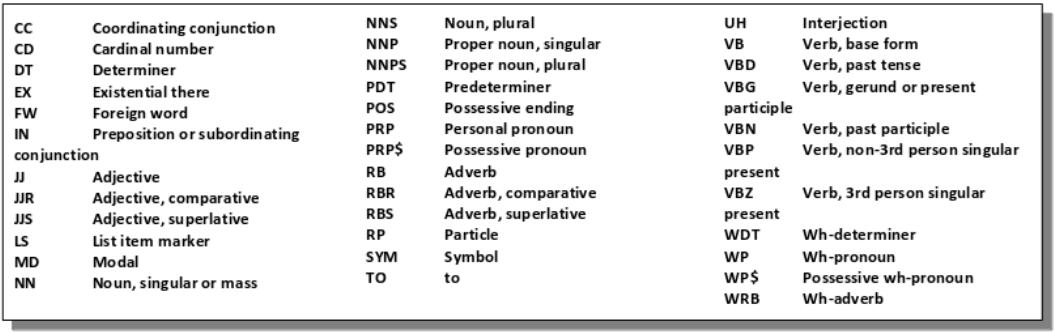

In [13]:
import nltk
from nltk import pos_tag, word_tokenize
from collections import defaultdict, Counter

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def calcular_frecuencia_pos(texto):
    # Tokenizar y obtener POS tags
    tokens = word_tokenize(texto)
    pos_tags = pos_tag(tokens)

    # Contar frecuencia de cada POS tag
    frecuencia_pos = Counter(tag for _, tag in pos_tags)  # Usar Counter para facilitar el conteo

    return frecuencia_pos.most_common(5)  # Obtener las 5 más comunes


# Aplicar a cada categoría (asumiendo que 'articulos_por_categoria' ya está definido)
frecuencia_pos_por_categoria = {cat: calcular_frecuencia_pos(texto) for cat, texto in articulos_por_categoria.items()}

# Mostrar resultados
for categoria, frecuencia_pos in frecuencia_pos_por_categoria.items():
    print(f"\n🔹 Categoría: {categoria}")
    for tag, freq in frecuencia_pos:
        print(f"{tag}: {freq}")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



🔹 Categoría: science
NN: 43261
IN: 27742
DT: 25099
JJ: 24193
NNP: 20769

🔹 Categoría: technology
NNP: 41639
NN: 33187
IN: 28754
DT: 24042
JJ: 14741

🔹 Categoría: medicine
NNP: 47779
NN: 26645
IN: 25475
DT: 19242
JJ: 13916

🔹 Categoría: politics
NN: 38850
IN: 33971
NNP: 28848
DT: 27716
JJ: 23286

🔹 Categoría: sports
NNP: 36545
NN: 28025
IN: 23754
DT: 18755
JJ: 12428

🔹 Categoría: history
NNP: 58969
NN: 32125
IN: 31458
DT: 22278
JJ: 16334

🔹 Categoría: economics
NNP: 58882
IN: 38008
NN: 30488
DT: 22364
JJ: 15636


Creando una matriz TF-IDF para cada categoría obtenemos un peso para cada palabra en el vocabulario

In [14]:
def calcular_tfidf(textos_procesados_por_categoria):

    # Calcular la frecuencia de términos (TF) para cada categoría:
    tf_por_categoria = {}
    for categoria, tokens in textos_procesados_por_categoria.items():
        tf = {}
        for token in tokens:
            tf[token] = tf.get(token, 0) + 1
        tf_por_categoria[categoria] = tf

    # Calcular la frecuencia inversa de documentos (IDF) para cada término:
    idf = {}
    num_categorias = len(textos_procesados_por_categoria)
    for categoria, tokens in textos_procesados_por_categoria.items():
        for token in set(tokens):  # Usar set para evitar contar tokens repetidos
            idf[token] = idf.get(token, 0) + 1
    for token, count in idf.items():
        idf[token] = math.log(num_categorias / count)

    # Calcular la matriz TF-IDF para cada categoría:
    tfidf_por_categoria = {}
    for categoria, tf in tf_por_categoria.items():
        tfidf = {}
        for token, freq in tf.items():
            tfidf[token] = freq * idf[token]
        tfidf_por_categoria[categoria] = tfidf

    return tfidf_por_categoria

In [15]:
import math

tfidf_matrices = calcular_tfidf(vocabularios_por_categoria)

# Imprimir las 10 palabras clave de cada categoría:
for categoria, tfidf in tfidf_matrices.items():
    top_10 = sorted(tfidf.items(), key=lambda item: item[1], reverse=True)[:10]
    print(f"\nPalabras clave para la categoría '{categoria}':")
    for palabra, valor_tfidf in top_10:
        print(f"  - {palabra}: {valor_tfidf:.4f}")


Palabras clave para la categoría 'science':
  - theorem: 1179.4386
  - particle: 751.6578
  - symmetry: 641.4146
  - equation: 471.0976
  - quantum: 415.7945
  - μ: 354.1556
  - angular: 299.6702
  - ψ: 280.2111
  - electron: 220.4863
  - conserved: 219.2335

Palabras clave para la categoría 'technology':
  - museum: 488.9660
  - pumping: 404.7493
  - locomotive: 247.1306
  - steam: 238.3963
  - machinery: 111.4959
  - engine: 109.4470
  - aircraft: 104.2176
  - interactive: 90.1989
  - exhibition: 90.1746
  - colliery: 85.6200

Palabras clave para la categoría 'medicine':
  - hospital: 956.1967
  - pediatric: 260.7520
  - clinic: 202.5042
  - patient: 196.1633
  - hôpital: 182.9156
  - dental: 161.6064
  - maternity: 152.8371
  - outpatient: 148.2771
  - paediatric: 147.8892
  - kowloon: 147.8892

Palabras clave para la categoría 'politics':
  - tory: 266.5897
  - democratic: 149.9717
  - politics: 131.8971
  - liberal: 120.7935
  - ballot: 119.0125
  - dalmatia: 110.9169
  - voter: 

In [36]:
import numpy as np
from collections import Counter

def chi2_vocab_selection(vocabularios_por_categoria, top_k=10):

    categorias = list(vocabularios_por_categoria.keys())

    # 🔹 Paso 1: Construcción del vocabulario total y conteo global
    conteo_por_categoria = {cat: Counter(tokens) for cat, tokens in vocabularios_por_categoria.items()}
    vocabulario_total = set(word for tokens in vocabularios_por_categoria.values() for word in tokens)

    total_docs = sum(len(tokens) for tokens in vocabularios_por_categoria.values())  # Total de palabras

    # 🔹 Paso 2: Cálculo de Chi-cuadrado
    chi2_scores = {cat: {} for cat in categorias}

    for palabra in vocabulario_total:
        # Calcular ocurrencias globales de la palabra
        total_A = sum(conteo_por_categoria[cat][palabra] for cat in categorias)  # Presencia en todo el dataset

        for categoria in categorias:
            A = conteo_por_categoria[categoria][palabra]  # Presente en la categoría
            B = total_A - A  # En otras categorías
            C = len(vocabularios_por_categoria[categoria]) - A  # No aparece en la categoría
            D = total_docs - (A + B + C)  # No aparece en todo el dataset

            # Evitar división por cero
            denom = (A + C) * (B + D) * (A + B) * (C + D)
            if denom == 0:
                continue

            # Calcular Chi-cuadrado
            chi2 = ((A * D - B * C) ** 2) * total_docs / denom
            chi2_scores[categoria][palabra] = chi2

    # 🔹 Paso 3: Seleccionar las palabras con mayor Chi-cuadrado por categoría
    mejores_palabras = {cat: sorted(chi2_scores[cat].items(), key=lambda x: x[1], reverse=True)[:top_k] for cat in categorias}

    return mejores_palabras

mejores_palabras_por_categoria = chi2_vocab_selection(vocabularios_por_categoria, top_k=10)

# 🔹 Mostrar resultados
for categoria, palabras in mejores_palabras_por_categoria.items():
    print(f"\n🔹 Categoría: {categoria}")
    for palabra, score in palabras:
        print(f"  - {palabra}: {score:.2f}")



🔹 Categoría: science
  - theorem: 9178.61
  - law: 7817.86
  - quantum: 5038.54
  - constant: 4788.07
  - particle: 4063.08
  - equation: 3602.94
  - symmetry: 3480.46
  - n: 3292.52
  - x: 3283.85
  - energy: 3264.19

🔹 Categoría: technology
  - museum: 17547.73
  - engine: 3948.76
  - collection: 3646.26
  - steam: 2515.75
  - company: 2005.58
  - computer: 1914.55
  - technology: 1736.88
  - station: 1544.81
  - exhibit: 1445.14
  - exhibition: 1402.95

🔹 Categoría: medicine
  - hospital: 39353.44
  - medical: 6774.91
  - health: 5910.33
  - care: 4824.12
  - patient: 3612.99
  - service: 3406.70
  - medicine: 2976.08
  - centre: 2672.37
  - hong: 2471.54
  - kong: 2440.84

🔹 Categoría: politics
  - party: 6426.49
  - political: 5159.38
  - term: 2244.67
  - government: 1652.77
  - liberal: 1560.75
  - election: 1520.50
  - politics: 1394.17
  - candidate: 1359.85
  - conservative: 1182.79
  - hospital: 1147.62

🔹 Categoría: sports
  - film: 7129.67
  - medal: 4572.24
  - champions

# 3. Implementar reglas de clasficicación

Despues de haber encontrado características lingüísticas para cada categoría se hace el modelo de clasficacaión basado en estas.

In [41]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

class ClasificadorTexto:
    def __init__(self, metodo="chi2"):
        # Palabras clave obtenidas por TF-IDF
        self.palabras_tfidf = {
            "science": {"theorem", "particle", "symmetry", "equation", "quantum", "μ", "angular", "ψ", "electron", "conserved"},
            "technology": {"museum", "pumping", "locomotive", "steam", "machinery", "engine", "aircraft", "interactive", "exhibition", "colliery"},
            "medicine": {"hospital", "pediatric", "clinic", "patient", "hôpital", "dental", "maternity", "outpatient", "paediatric", "kowloon"},
            "politics": {"tory", "democratic", "politics", "liberal", "ballot", "dalmatia", "voter", "socialism", "populism", "canadian"},
            "sports": {"taekwondo", "silambam", "championship", "karate", "kalaripayattu", "kerala", "martial", "iranian", "tamil", "wushu"},
            "history": {"carolina", "bern", "kansa", "craven", "stanly", "edenton", "shawnee", "allie", "raleigh", "town"},
            "economics": {"economics", "economist", "monetary", "macroeconomics", "keynesian", "keynes", "drees", "zijlstra", "duisenberg", "econometrics"}
        }

        # Palabras clave obtenidas por Chi-cuadrado
        self.palabras_chi2 = {
            "science": {"theorem", "law", "quantum", "constant", "particle", "equation", "symmetry", "n", "x", "energy"},
            "technology": {"museum", "engine", "collection", "steam", "company", "computer", "technology", "station", "exhibit", "exhibition"},
            "medicine": {"hospital", "medical", "health", "care", "patient", "service", "medicine", "centre", "hong", "kong"},
            "politics": {"party", "political", "term", "government", "liberal", "election", "politics", "candidate", "conservative", "hospital"},
            "sports": {"film", "medal", "championship", "asian", "martial", "iranian", "indian", "sport", "game", "team"},
            "history": {"city", "carolina", "capital", "population", "built", "north", "bern", "town", "begin", "established"},
            "economics": {"economics", "economic", "university", "professor", "economist", "monetary", "policy", "research", "economy", "theory"}
        }

        # Seleccionar las palabras clave según el método
        self.categorias = {}
        palabras_clave = self.palabras_tfidf if metodo == "tfidf" else self.palabras_chi2

        for categoria in palabras_clave:
            self.categorias[categoria] = {
                "long_palabra": 4.5,  # Valores aproximados
                "long_oracion": 25.0,
                "palabras_clave": palabras_clave[categoria]
            }

    def calcular_longitudes(self, texto):
        palabras = word_tokenize(texto)
        oraciones = sent_tokenize(texto)

        long_palabras = sum(len(p) for p in palabras) / len(palabras) if palabras else 0
        long_oraciones = sum(len(word_tokenize(o)) for o in oraciones) / len(oraciones) if oraciones else 0

        return long_palabras, long_oraciones

    def clasificar(self, texto):
        long_palabras, long_oraciones = self.calcular_longitudes(texto)
        palabras = word_tokenize(texto)

        conteo_palabras_clave = {categoria: sum(1 for palabra in palabras if palabra.lower() in info["palabras_clave"])
                                 for categoria, info in self.categorias.items()}

        puntuaciones = {}
        for categoria, info in self.categorias.items():
            puntuacion = 0
            puntuacion += abs(long_oraciones - info["long_oracion"]) < 5  # Similitud en longitud de oración
            puntuacion += conteo_palabras_clave[categoria] * 2  # Mayor peso a palabras clave
            puntuaciones[categoria] = puntuacion

        return max(puntuaciones, key=puntuaciones.get)

# 4. Evaluación del clasificador

Ahora se extraen 1000 textos para probar el clasficador.

In [19]:
import wikipediaapi
import pandas as pd
import time
import concurrent.futures

# Configurar Wikipedia API con User-Agent
user_agent = "MyWikipediaScraper/1.0 (contact: your_email@example.com)"
accuracy = 77.62
wiki = wikipediaapi.Wikipedia(language="en", user_agent=user_agent)

# Definir categorías de Wikipedia a extraer
categorias = {
    "politics": "Category:Political_terminology",
    "economics": "Category:Economics",
    "science": "Category:Science",
    "technology": "Category:Technology",
    "history": "Category:History",
    "medicine": "Category:Medicine",
    "sports": "Category:Sports"
}

# Función para identificar si un artículo es una biografía
def es_biografia(titulo):
    palabras_clave = ["born", "died", "biography", "person", "historian", "scientist", "politician"]
    return any(palabra in titulo.lower() for palabra in palabras_clave)

# Función para obtener artículos de una categoría (con límite de profundidad)
def obtener_articulos_categoria(categoria, min_articulos, profundidad_max=2):
    categoria_wiki = wiki.page(categoria)
    articulos_validos = set()

    def extraer_articulos(pagina, nivel):
        if nivel > profundidad_max:
            return  # Detenerse si se alcanza el nivel máximo

        for titulo, contenido in pagina.categorymembers.items():
            if len(articulos_validos) >= min_articulos:
                return  # Si ya tenemos suficientes, salimos

            if contenido.ns == wikipediaapi.Namespace.MAIN:  # Es un artículo real
                if not titulo.startswith("Category:") and not es_biografia(titulo):
                    articulos_validos.add(titulo)

            elif contenido.ns == wikipediaapi.Namespace.CATEGORY:  # Explorar subcategorías
                extraer_articulos(contenido, nivel + 1)

    extraer_articulos(categoria_wiki, nivel=0)

    return list(articulos_validos)[:min_articulos]  # Devolver solo los necesarios

# Función para obtener el texto de un artículo (con manejo de errores)
def obtener_texto(tema):
    pagina = wiki.page(tema)
    if pagina.exists():
        return pagina.text[:3000]  # Limitar a 3000 caracteres por artículo
    return None

# Extraer datos de Wikipedia usando concurrencia
datos = []

# Reducir la cantidad de artículos por categoría para obtener un total de aproximadamente 1000 textos
min_articulos_por_categoria = 150  # Ajustado para alcanzar ~1000 textos en total

def procesar_categoria(categoria, categoria_wiki):
    print(f"\n🔍 Obteniendo artículos de la categoría: {categoria}...")

    articulos = obtener_articulos_categoria(categoria_wiki, min_articulos_por_categoria)

    resultados = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # 2 hilos concurrentes
        futuros = {executor.submit(obtener_texto, articulo): articulo for articulo in articulos}

        for futuro in concurrent.futures.as_completed(futuros):
            articulo = futuros[futuro]
            try:
                texto = futuro.result()
                if texto:
                    resultados.append([articulo, texto, categoria])
                    print(f"✅ {articulo} agregado ({categoria})")
            except Exception as e:
                print(f"❌ Error con {articulo}: {e}")

    return resultados

# Ejecutar extracción en paralelo
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:  # 3 categorías a la vez
    futuros = {executor.submit(procesar_categoria, cat, cat_wiki): cat for cat, cat_wiki in categorias.items()}

    for futuro in concurrent.futures.as_completed(futuros):
        datos.extend(futuro.result())

# Crear DataFrame con Pandas
df = pd.DataFrame(datos, columns=["title", "text", "category"])

# Mezclar aleatoriamente los artículos
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


🔍 Obteniendo artículos de la categoría: politics...

🔍 Obteniendo artículos de la categoría: economics...

🔍 Obteniendo artículos de la categoría: science...
✅ Classification of advocacy groups agregado (politics)
✅ Coattail effect agregado (politics)
✅ Di Lampedusa strategy agregado (politics)
✅ Hate speech agregado (politics)
✅ CAVE people agregado (politics)
✅ Christian values agregado (politics)
✅ Plantas alimentícias não convencionais agregado (economics)
✅ Nanoelectromechanical systems agregado (science)
✅ Capper–Volstead Act agregado (economics)
✅ Centre-right politics agregado (politics)
✅ Decision theory agregado (science)
✅ Madan Sara agregado (economics)
✅ Favorite son agregado (politics)
✅ Agricultural policy agregado (economics)
✅ Dear Colleague letter agregado (politics)
✅ Social work agregado (science)
✅ Gross processing margin agregado (economics)
✅ Democratic legitimacy of the European Union agregado (politics)
✅ Criminology agregado (science)
✅ Appearance of impropri

In [20]:
# Guardar en CSV
df.to_csv("wikipedia_data_test.csv", index=False, encoding="utf-8")

print(f"\n📂 Se han guardado {len(df)} artículos en 'wikipedia_data_test.csv'")


📂 Se han guardado 1050 artículos en 'wikipedia_data_test.csv'


In [21]:
# Cargar el dataset
df_test = pd.read_csv("wikipedia_data_test.csv")

# Ver estructura
print(df_test.head())
print(f"\nEl dataset cuenta con {df_test.shape[0]} observaciones y {df_test.shape[1]} dimensiones.")

                           title  \
0                     Bioculture   
1                   Belle Époque   
2  Telecommunications in Grenada   
3        Artificial intelligence   
4      Armenia without Armenians   

                                                text    category  
0  Bioculture is the combination of biological an...     science  
1  The Belle Époque (French pronunciation: [bɛlep...     history  
2  Communications in Grenada\n\nTelephone\nCountr...  technology  
3  Artificial intelligence (AI) refers to the cap...     science  
4  "Armenia without Armenians" is a phrase with d...    politics  

El dataset cuenta con 1050 observaciones y 3 dimensiones.


In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Cargar stopwords en inglés
stop_words = set(stopwords.words("english"))

# Función de preprocesamiento (tokenización, normalización, lematización)
def procesar_texto(texto):
    tokens = word_tokenize(texto.lower())  # Convertir a minúsculas y tokenizar
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # Eliminar stopwords y signos de puntuación
    tokens = lemmatization(tokens)  # Aplicar lematización
    return tokens

# Aplicar preprocesamiento a los textos de prueba
df_test["processed_text"] = df_test["text"].apply(procesar_texto)

# Instanciar el clasificador basado en reglas
clasificador = ClasificadorTexto()

# Clasificar cada texto de prueba
df_test["predicted_category"] = df_test["text"].apply(clasificador.clasificar)

# Evaluar precisión del modelo
accuracy = (df_test["predicted_category"] == df_test["category"]).mean()
print(f"\n📊 Precisión del modelo en el conjunto de prueba: {accuracy:.2%}")



📊 Precisión del modelo en el conjunto de prueba: 55.43%


Si el modelo de clasificación usa matrices TF-IDF obtiene el 37.43% de precisión, por otro lado si usa las palabras clave obtenidas por chi cuadrada sube a 55.43%

# 5. Visualización de la distribución de documentos.

In [52]:
# Aplicar el clasificador a cada texto en el dataframe
df_test["predicted_category"] = df_test["text"].apply(clasificador.clasificar)

# Mostrar algunas filas para verificar
print(df_test[['text', 'predicted_category']].head())

                                                text predicted_category
0  Bioculture is the combination of biological an...           politics
1  The Belle Époque (French pronunciation: [bɛlep...           politics
2  Communications in Grenada\n\nTelephone\nCountr...           medicine
3  Artificial intelligence (AI) refers to the cap...          economics
4  "Armenia without Armenians" is a phrase with d...           politics


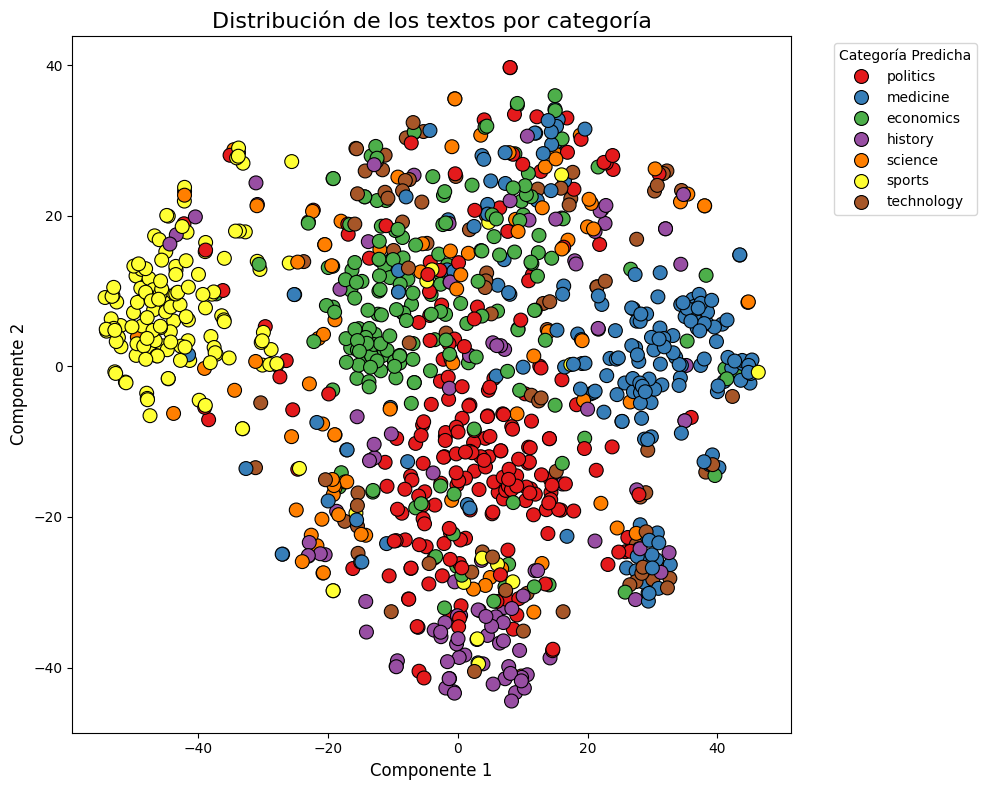

In [53]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

# Paso 1: Crear la representación TF-IDF de los textos
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df_test["text"])

# Paso 2: Aplicar t-SNE para reducir la dimensionalidad a 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Paso 3: Crear un DataFrame con las coordenadas 2D y las categorías predichas
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['predicted_category'] = df_test['predicted_category']

# Paso 4: Graficar los resultados
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='predicted_category', palette='Set1', s=100, edgecolor='k', marker='o')

# Mejorar la visualización
plt.title('Distribución de los textos por categoría', fontsize=16)
plt.xlabel('Componente 1', fontsize=12)
plt.ylabel('Componente 2', fontsize=12)
plt.legend(title='Categoría Predicha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()